In [1]:
import glob
from NOREC4DNA.norec4dna import get_error_correction_decode,RU10Decoder
from NOREC4DNA.norec4dna.distributions.RaptorDistribution import RaptorDistribution
from cluster_exp import raptor_dist, bmp_low_entropy_evo_dist, bmp_low_entropy_diff_dist, \
    evo_compress_encrypt_high_entropy_dist, diff_compress_encrypt_high_entropy_dist
from NOREC4DNA.norec4dna.helper.RU10Helper import intermediate_symbols


In [19]:
def decode_from_fasta(filename, number_of_chunks, dist, error_correction, use_seed_xor, use_payload_xor, seed_spacing,
                      use_headerchunk):
    decoder = RU10Decoder(file=filename, error_correction=error_correction, use_headerchunk=use_headerchunk,
                          static_number_of_chunks=number_of_chunks, checksum_len_str=None,
                          xor_by_seed=use_payload_xor, mask_id=use_seed_xor, id_spacing=seed_spacing)

    decoder.distribution = RaptorDistribution(number_of_chunks)
    # update distribution.f:
    decoder.distribution.f = dist
    decoder.distribution.d = [x for x in range(0, 41)]
    decoder.number_of_chunks = number_of_chunks
    _, decoder.s, decoder.h = intermediate_symbols(number_of_chunks, decoder.distribution)
    decoder.createAuxBlocks()
    decoder.progress_bar = decoder.create_progress_bar(number_of_chunks + 0.02 * number_of_chunks)
    res = decoder.decodeFile(packet_len_format="I", crc_len_format="I",
                             number_of_chunks_len_format="I", id_len_format="H")
    print(f"Success: {res}")
    res_data = decoder.saveDecodedFile(last_chunk_len_format="", null_is_terminator=True, print_to_output=False,
                            partial_decoding=True)
    return res, res_data


def get_dist(filename):
    if "raptor" in filename:
        return raptor_dist
    elif "low_entropy_evo" in filename:
        return bmp_low_entropy_evo_dist
    elif "low_entropy_diff" in filename:
        return bmp_low_entropy_diff_dist
    elif "evo_compress_encrypt" in filename:
        return evo_compress_encrypt_high_entropy_dist
    elif "diff_compress_encrypt" in filename:
        return diff_compress_encrypt_high_entropy_dist
    else:
        raise ValueError("Unknown dist")


def get_seed_spacing(filename):
    if not "seedspacing" in filename:
        return 0
    else:
        return int(filename.replace("_payloadxor", "").split("seedspacing")[1].split(".")[0])


def get_payload_xor(filename):
    return "_payloadxor" in filename

In [128]:
# load mesa_config.json into a dict:
import json
import requests
config = json.load(open("mesa_config.json"))
# send a post request to 127.0.0.1:5000/api/all using the config as the requestbody:

def apply_multiplier(config, multiplier):
    for err_rule in ["homopolymer_error_prob", "gc_error_prob"]:
        for key in range(len(config[err_rule]["data"])):
            config[err_rule]["data"][key]["y"] *= min(100.0, multiplier)
    return config
        

def get_mesa_errors_seqs(sequence, error_multiplier=1.0):
    config["key"] = "IgGD6Cfdlnqa4tUungucZpKp3hfYkt1IDqg0Bn3BxEE"
    config["asHTML"] = False
    config["sequence"] = sequence
    mesa_config = apply_multiplier(config, error_multiplier)
    res = requests.post("http://127.0.0.1:5000/api/all", json=mesa_config)
    return res.json()[sequence]["res"]["modified_sequence"].replace(" ", "")

def random_errors(sequences, error_rate=0.013, seq_drop_rate=0.00001):
    # apply random errors to the sequences such that the overall per base error rate is error_rate. An error may not lead to the correct base!:
    import random
    import numpy as np
    error_rate = min(1.0, error_rate)
    error_rate = max(0.0, error_rate)
    out_seqs = []
    for seq in sequences:
        if random.random() < seq_drop_rate:
            continue # dont add the sequence to the output list
        for i in range(len(seq)):
            if random.random() < error_rate:
                mode = np.random.choice(["sub", "ins", "del"], 1, p=[0.8, 0.1, 0.1])[0]
                if mode == "sub":
                    seq = seq[:i] + random.choice(list({"A", "T", "G", "C"}.difference(seq[i]))) + seq[i+1:]
                elif mode == "ins":
                    seq = seq[:i] + random.choice(list({"A", "T", "G", "C"})) + seq[i:]
                else:
                    seq = seq[:i] + " " + seq[i+1:]
        out_seqs.append(seq.replace(" ",""))
    return out_seqs

#get_mesa_errors_seqs("ACACCAGTTGC")
random_errors(["ACGGCTCGCATACG","AAAAAAAA"], 0.01, -0.0001)

['ACGGCTCGCATACG', 'AAAAAAAA']

In [65]:
import random
from copy import deepcopy
import yaml
from time import time


def modify_seq(original, pos, probs, results, counter, seqcount, base=None):
    pos_sub = []
    pos_ins = []
    pos_del = []
    sub_val = probs["substitution"]
    del_val = sub_val + probs["deletion"]
    ins_val = del_val + probs["insertion"]
    for p in pos:
        ran_num = np.random.randint(0, 100)
        if ran_num <= sub_val:
            pos_sub.append(p)
        elif ran_num <= del_val:
            pos_del.append(p)
        else:
            pos_ins.append(p)
    #print(pos_sub, pos_del, pos_ins)
    results[str(counter)][str(seqcount)]["sub_pos"] = pos_sub
    results[str(counter)][str(seqcount)]["ins_pos"] = pos_ins
    results[str(counter)][str(seqcount)]["del_pos"] = pos_del
    modified = deepcopy(original)
    if pos_sub:
        modified = substitutions(modified, pos_sub)
    if pos_ins:
        modified = insertions(modified, pos_ins)
    if pos_del:
        modified = deletions(modified, pos_del)
    return (modified, len(pos_sub), len(pos_ins), len(pos_del))


def modify_file(in_path, out_path, probs, results, counter, err_list, weights):
    linecount = 0
    seqcount = 0
    errcount = 0
    subcount = 0
    inscount = 0
    delcount = 0
    modseqscount = 0
    with open(in_path, "r") as inp, open(out_path, "w") as out:
        while True:
            line = inp.readline()
            linecount += 1
            if not line:
                break
            if linecount % 2 != 0:
                out.write(line)
            else:
                ori = line.strip()
                num_errs = np.random.choice(err_list, 1, p=weights)[0] #p=[0.4, 0.3, 0.2, 0.05, 0.05]
                errcount += num_errs
                results[str(counter)][str(seqcount)] = dict()
                results[str(counter)][str(seqcount)]["num_errs"] = int(num_errs)
                if not num_errs:
                    out.write(line)
                else:
                    modseqscount += 1
                    pos = random.sample(range(0, len(ori)), num_errs)
                    results[str(counter)][str(seqcount)]["error_pos"] = pos
                    seq, nsub, nins, ndels = modify_seq(ori, pos, probs, results, counter, seqcount)
                    subcount += nsub
                    inscount += nins
                    delcount += ndels
                    out.write(seq + "\n")
            seqcount += 1
        results[str(counter)]["number_of_errors"] = int(errcount)
        results[str(counter)]["number_of_modified_seqs"] = int(modseqscount)
        results[str(counter)]["number_of_substitutions"] = int(subcount)
        results[str(counter)]["number_of_insertions"] = int(inscount)
        results[str(counter)]["number_of_deletions"] = int(delcount)

def substitutions(original, pos, base=None):
    modified = deepcopy(original)
    for ele in pos:
        if not base:
            base = random.choice(list({"A", "T", "G", "C"}.difference(original[ele])))
        modified = modified[:ele] + base + modified[ele+1:]
    return modified


def insertions(original, pos, base=None):
    modified = deepcopy(original)
    shift = 0
    pos.sort()
    for ele in pos:
        if not base:
            base = random.choice(list({"A", "T", "G", "C"}))
        modified = modified[:ele+shift] + base + modified[ele+shift:]
        shift += 1
    return modified


def deletions(original, pos):
    modified = deepcopy(original)
    shift = 0
    pos.sort()
    for ele in pos:
        modified = modified[:ele-shift] + modified[ele-shift+1:]
    return modified


in_folder = "clusts/"
in_file = "cs_23_I_max_2_hp_10_gc_opt_sleeping_beauty_150_raptor_seedspacing0_payloadxor.fasta"
in_path = f"{in_folder}{in_file}"
out_path = f"{in_folder}error_test/{in_file}"
length = 116
probs = {"substitution": 80, "insertion": 10, "deletion": 10}
err_list = [0, 1, 2, 3, 4, 5, 6, 7]
weights = [0.15, 0.15, 0.25, 0.2, 0.1, 0.06, 0.05, 0.04] #weights = [0.35, 0.25, 0.15, 0.15, 0.05, 0.03, 0.01, 0.01]
iterations = 1
results = dict()
results["params"] = dict()
results["params"]["err_type"] = probs
results["params"]["num_errs"] = err_list
results["params"]["errs_weights"] = weights
counter = 0
results[str(counter)] = dict()
print("start")
start = time()
modify_file(in_path, out_path, probs, results, counter, err_list, weights)
end = time()
print(end - start)
with open("test_split.yaml", "w") as o_:
    yaml.dump(results, o_)

In [20]:
number_of_chunks = 289  # or 191?
files = glob.glob("clusts/cs_23_I_max_2_hp_10_gc_opt_sleeping_beauty_150_raptor_seedspacing0_payloadxor.fasta")

for file in files:
    error_correction = get_error_correction_decode("reedsolomon", 2)
    dist = get_dist(file)
    use_payload_xor = get_payload_xor(file)
    seed_spacing = get_seed_spacing(file)
    static_number_of_chunks = number_of_chunks
    print(f"Current file and settings: {file}, {dist}, {use_payload_xor}, {seed_spacing}, {static_number_of_chunks}")
    try:
        res = decode_from_fasta(file, number_of_chunks=number_of_chunks, dist=dist, error_correction=error_correction,
                                use_seed_xor=False, use_payload_xor=use_payload_xor, seed_spacing=seed_spacing,
                                use_headerchunk=False)
    except Exception as e:
        print(f"Error in {file}: {e}")
        raise e
        continue

Decoded Packets: 292
Corrupt Packets : 0
Success: True
Error in clusts/cs_23_I_max_2_hp_10_gc_opt_sleeping_beauty_150_raptor_seedspacing0_payloadxor.fasta: 'utf-8' codec can't decode byte 0xe4 in position 0: invalid continuation byte
<xml><var name="_dummy_ipython_val"  />
<var name="_dummy_special_var"  />
<var name="bmp_low_entropy_diff_dist" type="ndarray" qualifier="numpy" value="%5B      0.            1136.9807546     9091.20111762   12111.88508948%2C   13017.1708098    57959.04100808   71798.24459634   72487.1842063%2C  125647.56019394  167454.99443843  207887.59917079  253583.4801622%2C  261718.31786311  310984.9412345   321695.14945959  368816.37254484%2C  393617.58142113  398484.87252954  446229.27315371  469314.84015955%2C  477620.72923345  482476.68746324  520877.86792584  523718.64231146%2C  567701.29582963  591072.50115539  612037.48997345  628878.87686348%2C  681353.80436257  722346.76126439  770935.25023072  793475.63495812%2C  803332.69084969  847730.75224056  851048.79

 97%|#### | Correct: 288, Corrupt: ------, ETA:   0:00:00 Elapsed Time: 0:00:00

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 0: invalid continuation byte

In [ ]:


number_of_chunks = 2868
files = glob.glob("clusts/opt_lorem_ipsum100k.doc_150*.fasta")

for file in files:
    error_correction = get_error_correction_decode("reedsolomon", 2)
    dist = get_dist(file)
    use_payload_xor = get_payload_xor(file)
    seed_spacing = get_seed_spacing(file)
    static_number_of_chunks = number_of_chunks
    print(f"Current file and settings: {file}, {dist}, {use_payload_xor}, {seed_spacing}, {static_number_of_chunks}")
    try:
        res = decode_from_fasta(file, number_of_chunks=number_of_chunks, dist=dist, error_correction=error_correction,
                                use_seed_xor=False, use_payload_xor=use_payload_xor, seed_spacing=seed_spacing,
                                use_headerchunk=False)
    except Exception as e:
        print(f"Error in {file}: {e}")
        continue

### MFE:

In [6]:
import pandas as pd
import numpy as np
import json
df = json.load(open("clusts/mfe_new.json"))

In [12]:
df

{'clusts\\cs_21_I_max_2_hp_10_gc_opt_sleeping_beauty_150_bmp_low_entropy_diff_dist_seedspacing0.fasta': [-41.890140533447266,
  -25.982378005981445,
  -28.468299865722656,
  -33.52229309082031,
  -31.307048797607422,
  -20.950843811035156,
  -33.87535858154297,
  -21.098047256469727,
  -27.62544059753418,
  -25.0737247467041,
  -26.65127944946289,
  -28.10233497619629,
  -27.526058197021484,
  -21.838470458984375,
  -33.57925796508789,
  -35.15162658691406,
  -40.167320251464844,
  -23.18014144897461,
  -44.018795013427734,
  -29.602916717529297,
  -32.60961151123047,
  -32.17914581298828,
  -25.493528366088867,
  -28.887310028076172,
  -36.14031982421875,
  -29.16461753845215,
  -35.3677864074707,
  -34.33792495727539,
  -25.225175857543945,
  -36.198020935058594,
  -28.003509521484375,
  -27.624317169189453,
  -27.920713424682617,
  -34.069252014160156,
  -28.848236083984375,
  -23.25688362121582,
  -30.1241455078125,
  -24.37624740600586,
  -25.01712989807129,
  -32.7597541809082,
 

In [11]:
out = {}
print(df)
for key, value in df.items():
    print(f"{key}, min {np.mean(value)}, std {np.std(value)}, max {np.max(value)}")
    out[key] = np.mean(value)
#print(df)

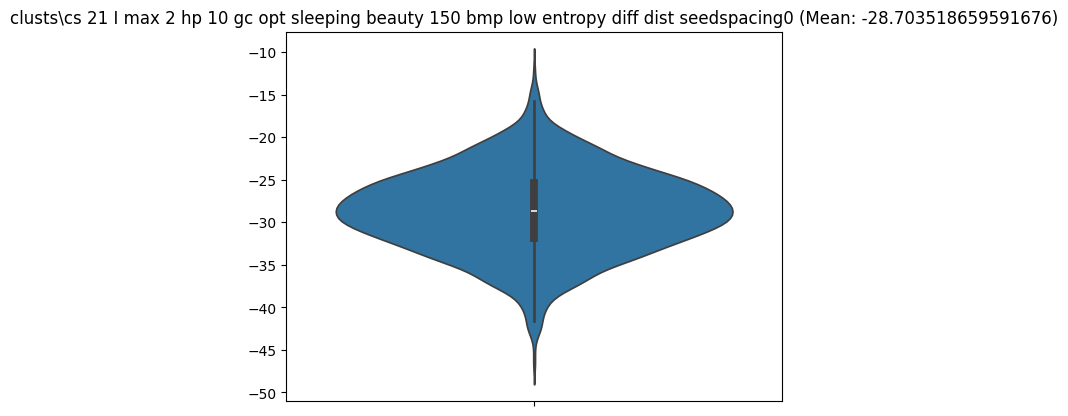

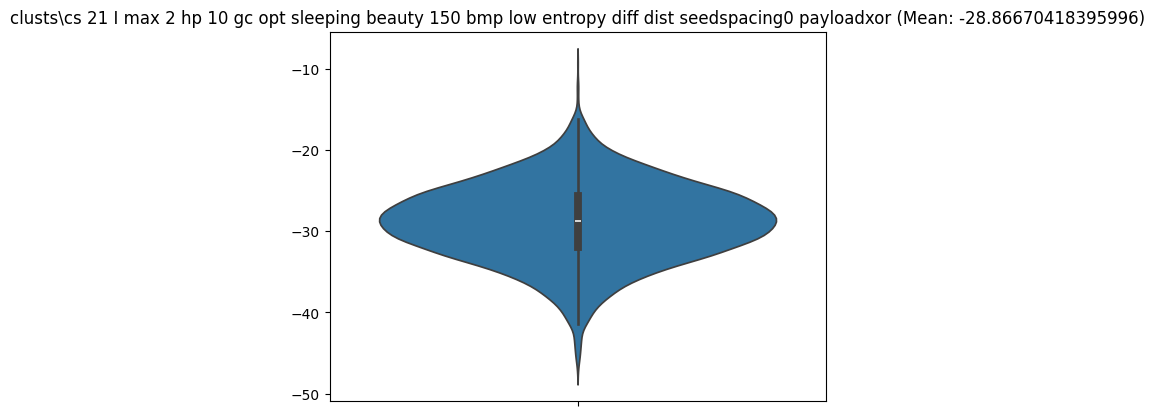

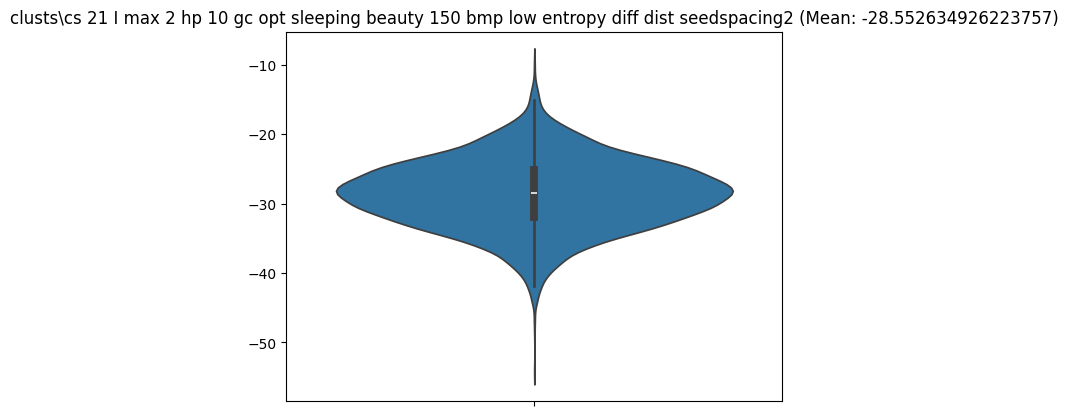

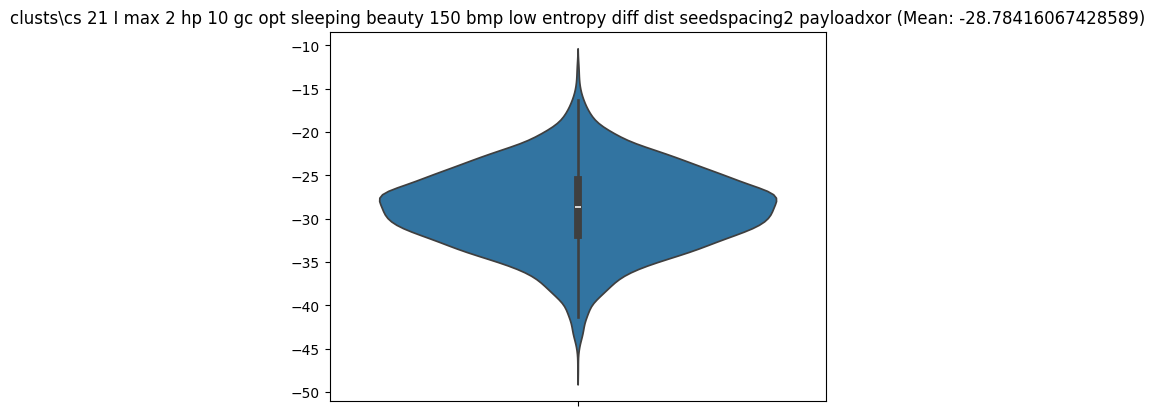

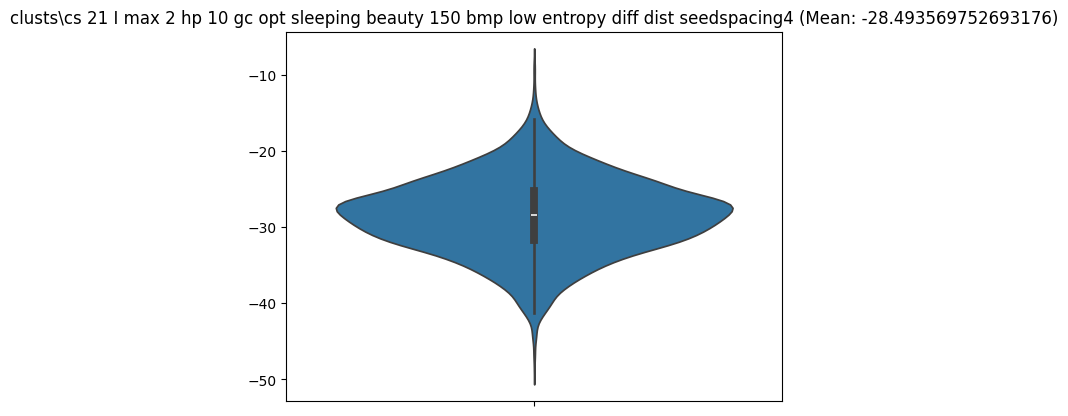

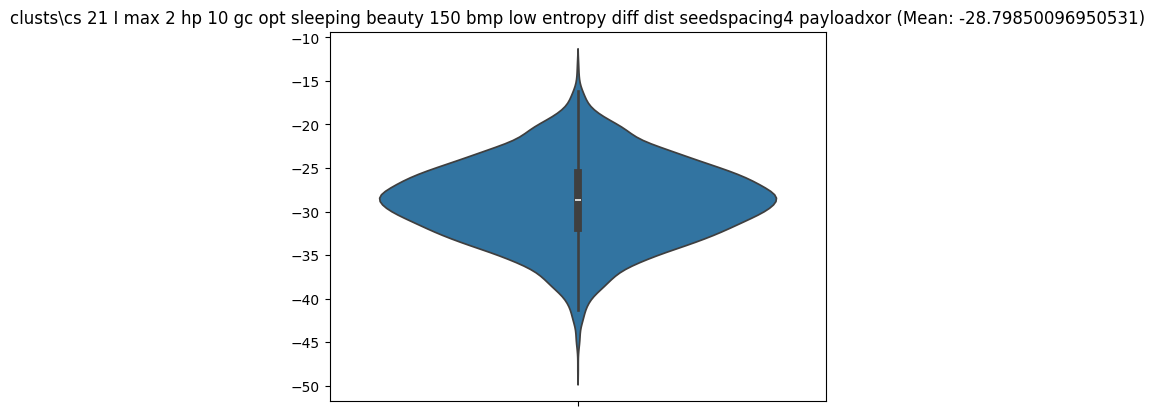

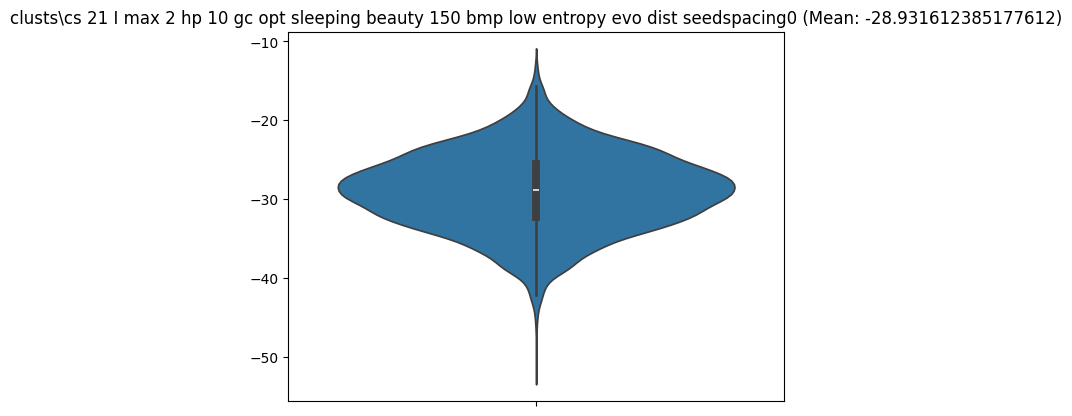

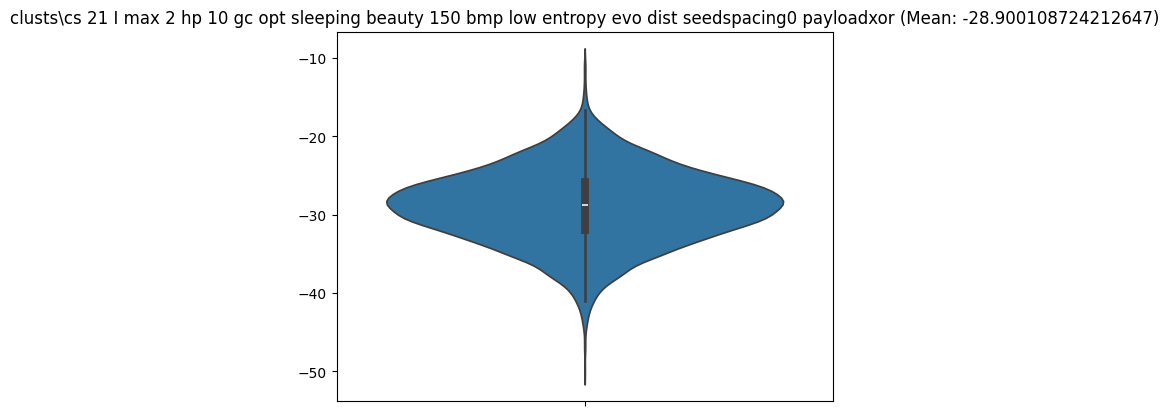

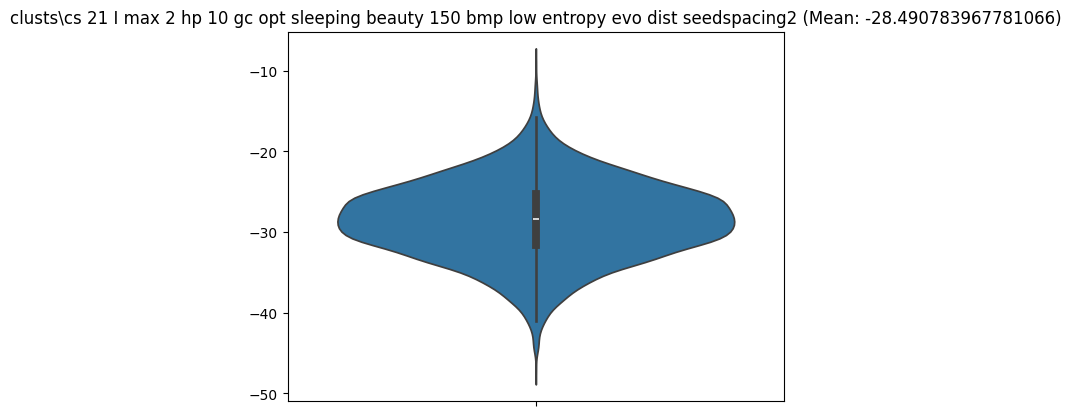

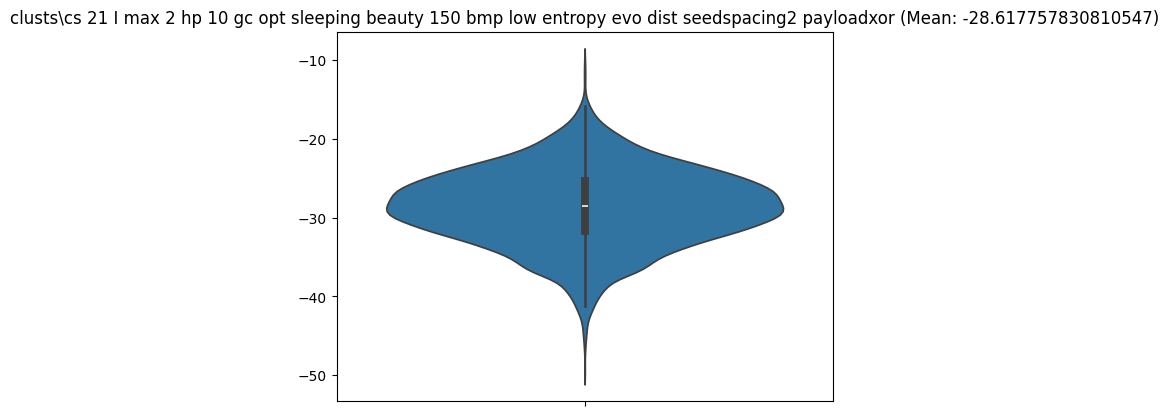

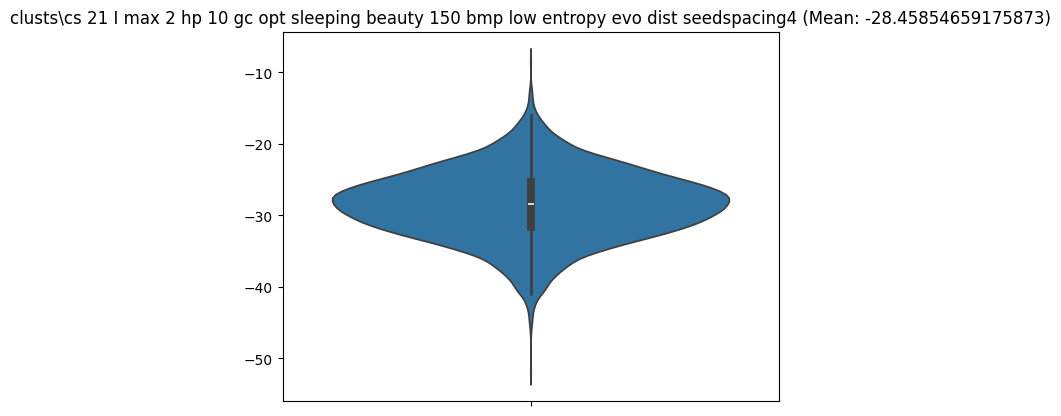

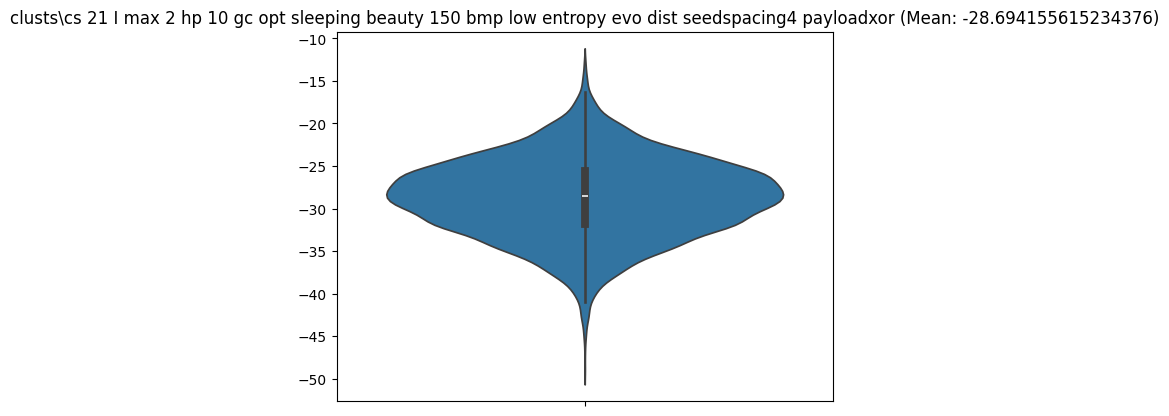

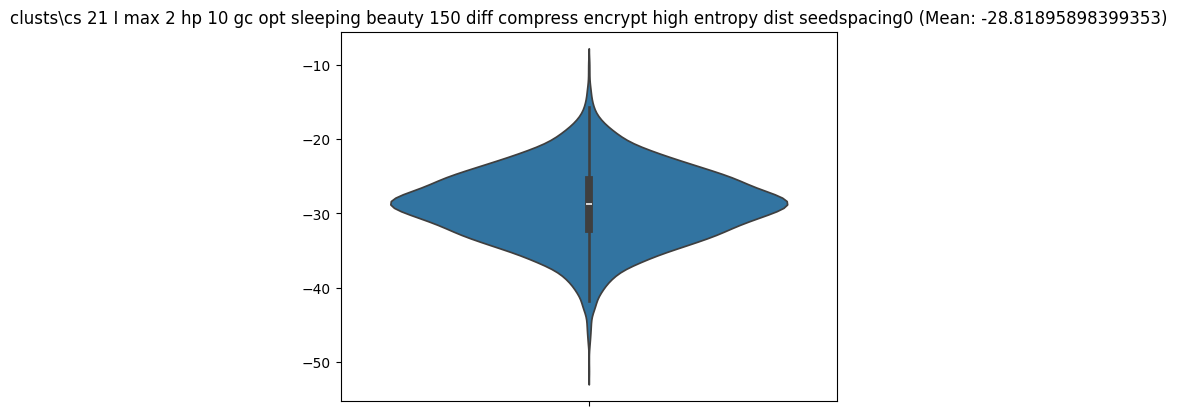

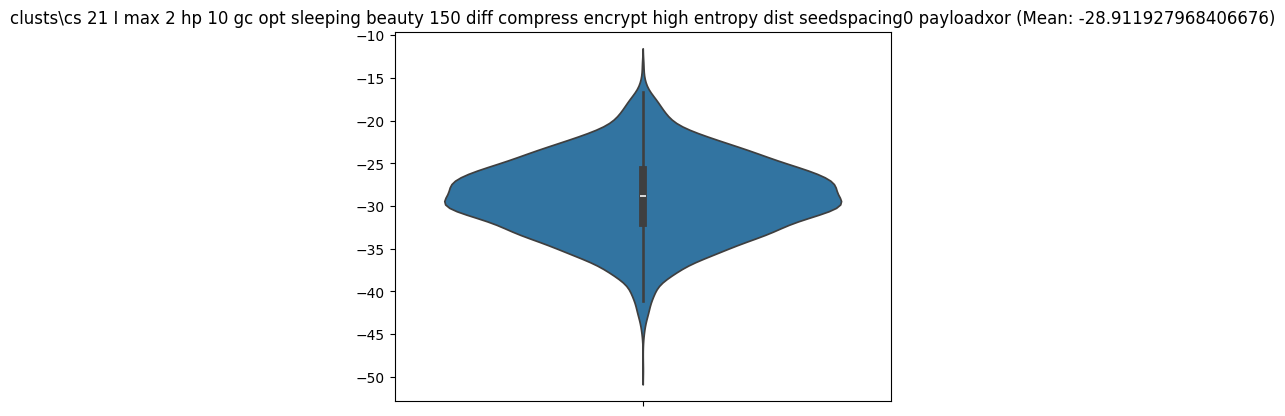

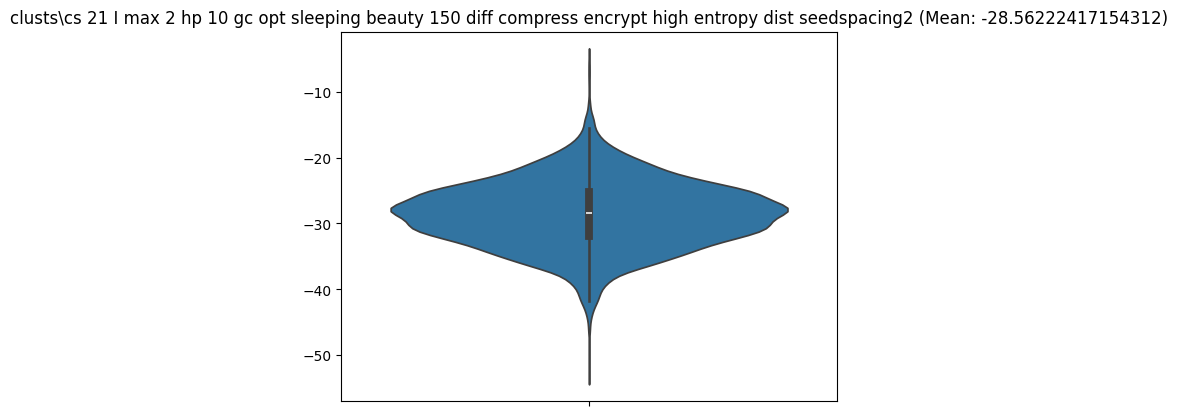

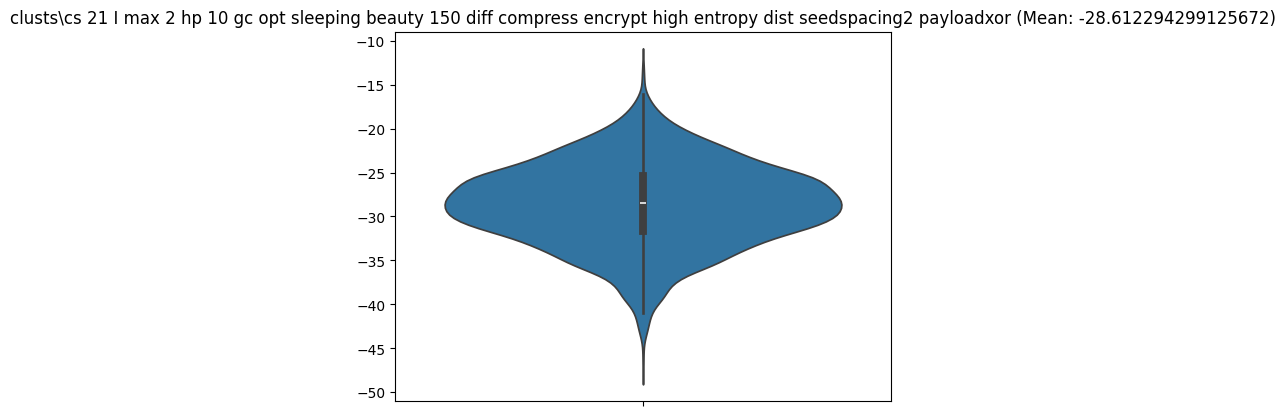

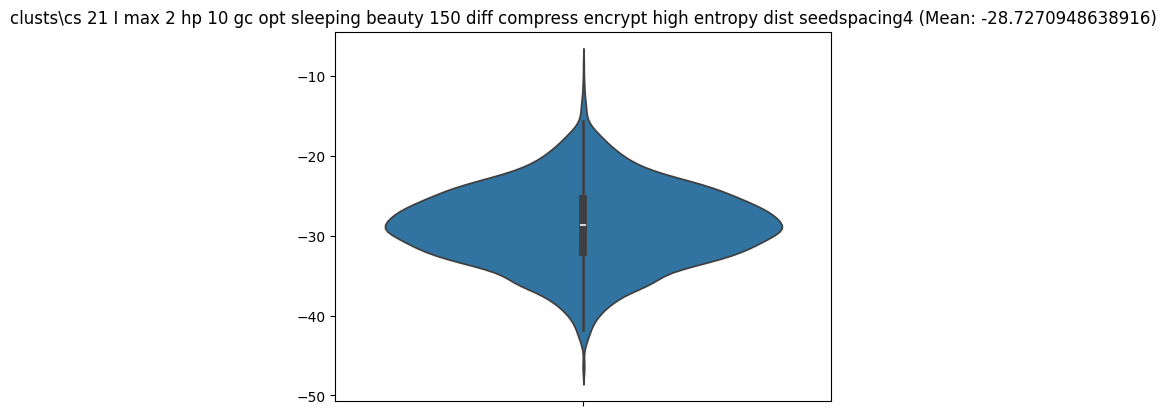

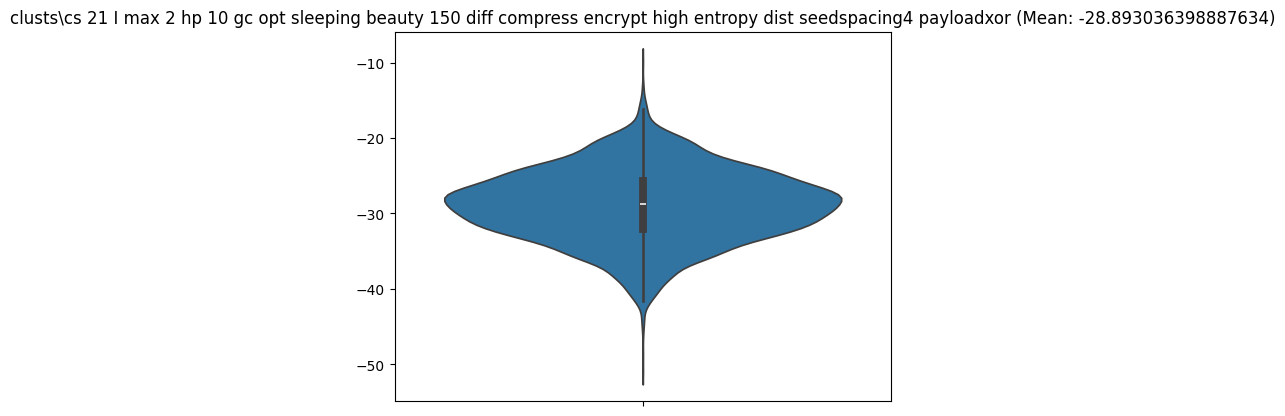

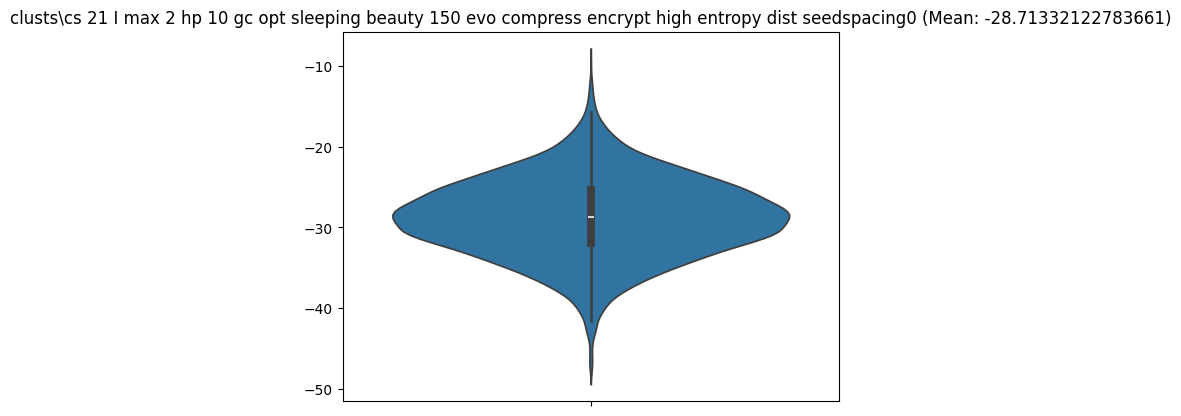

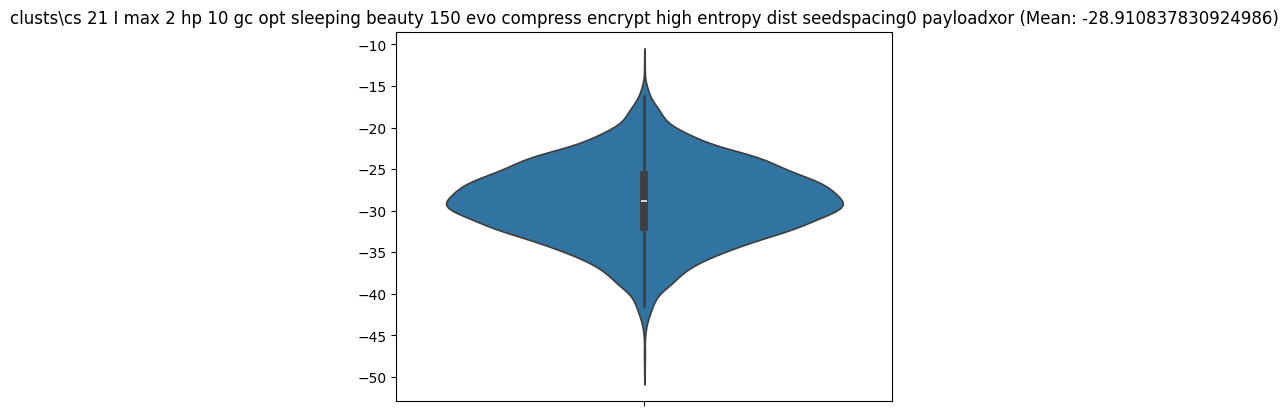

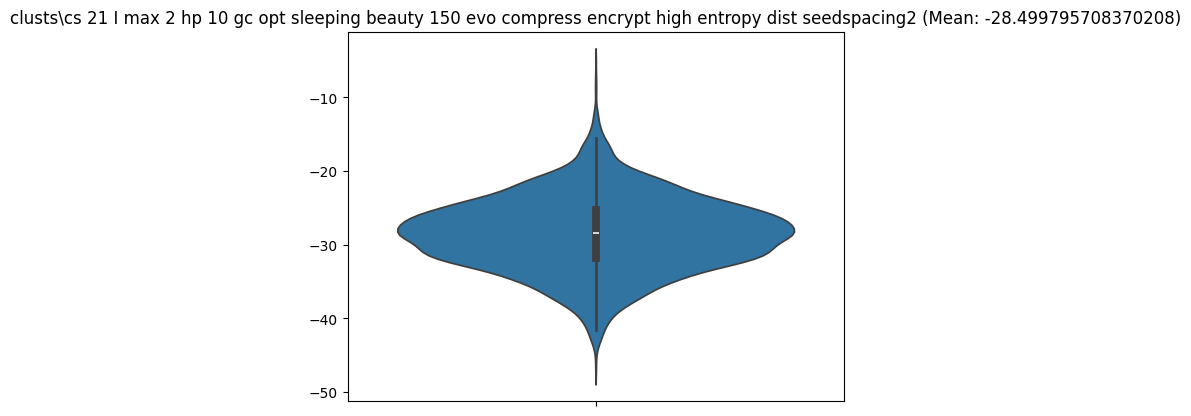

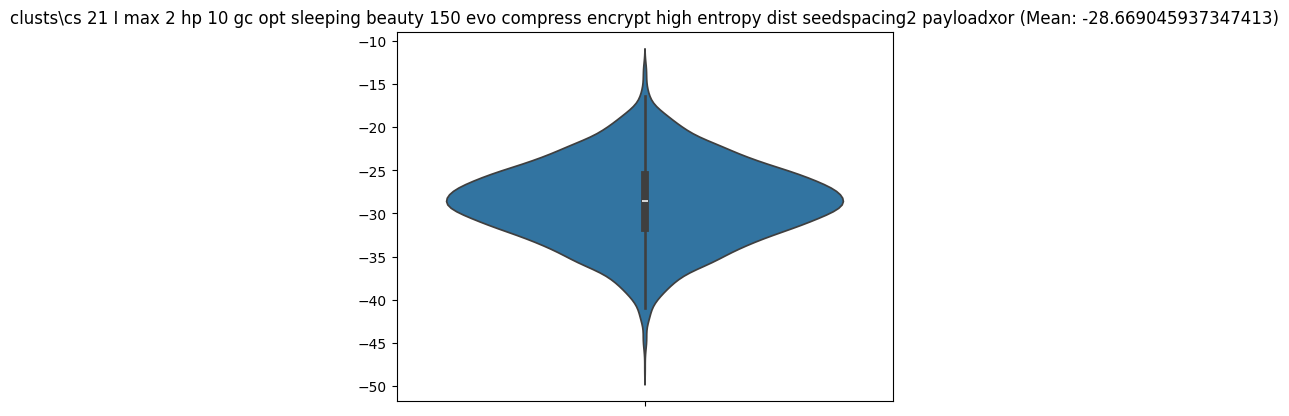

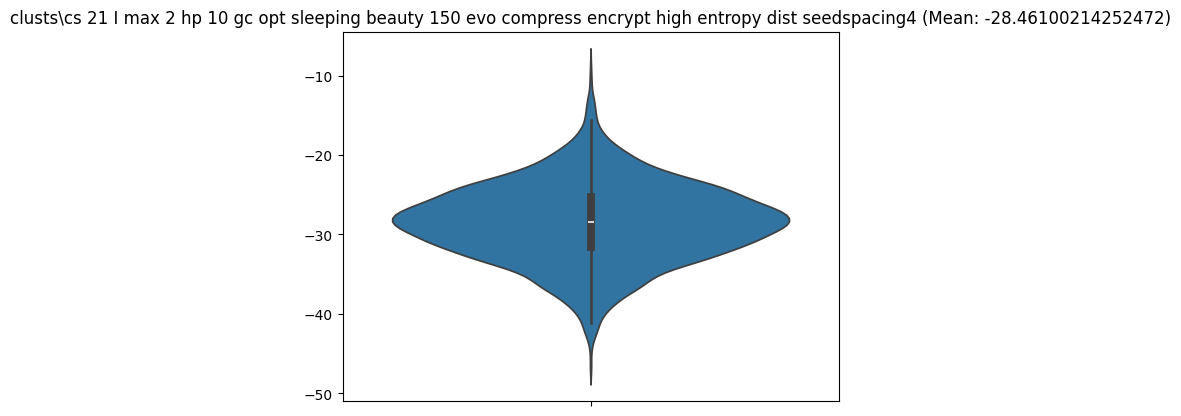

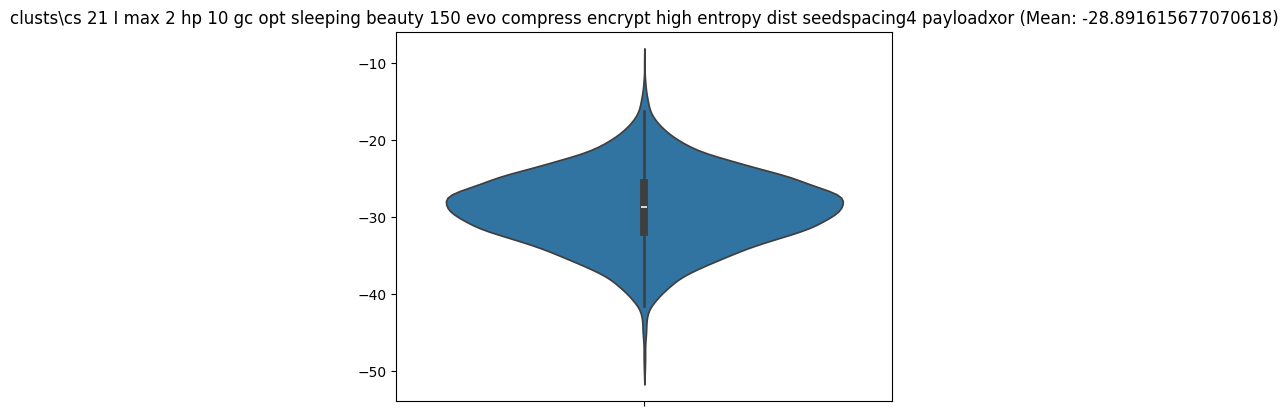

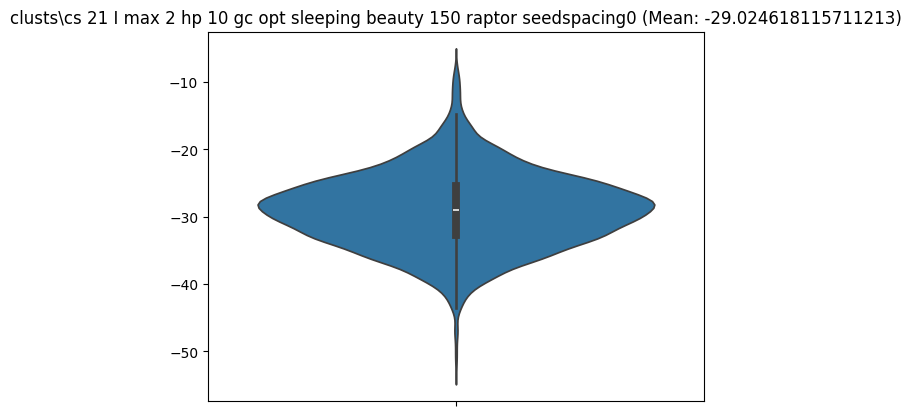

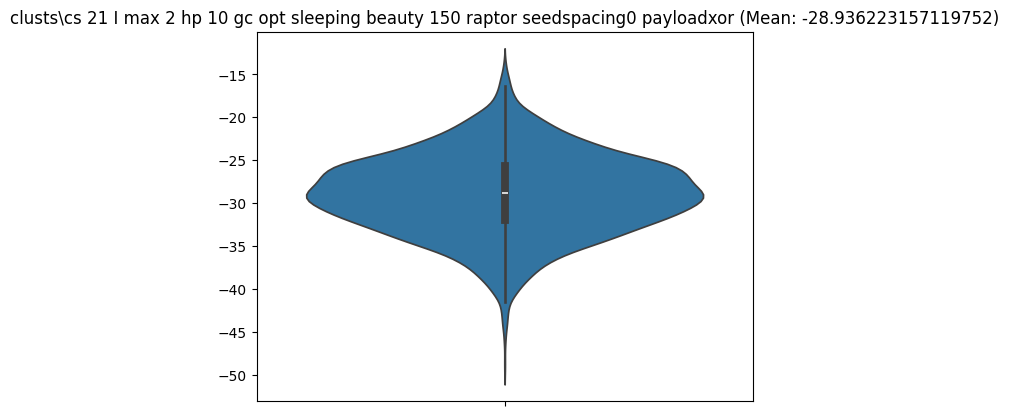

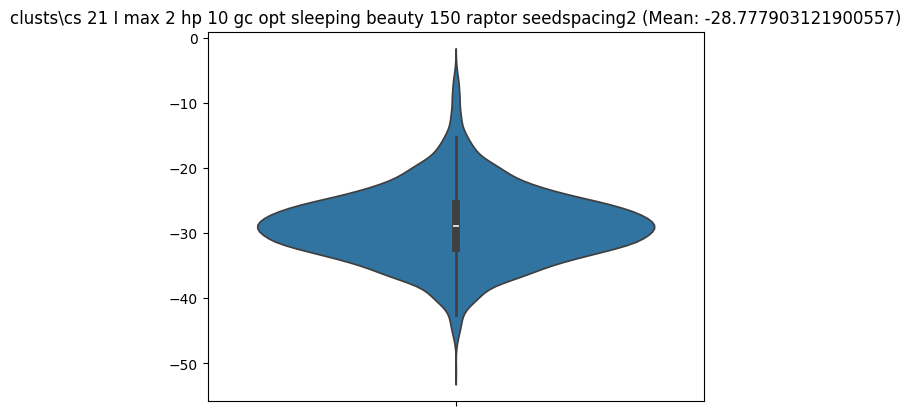

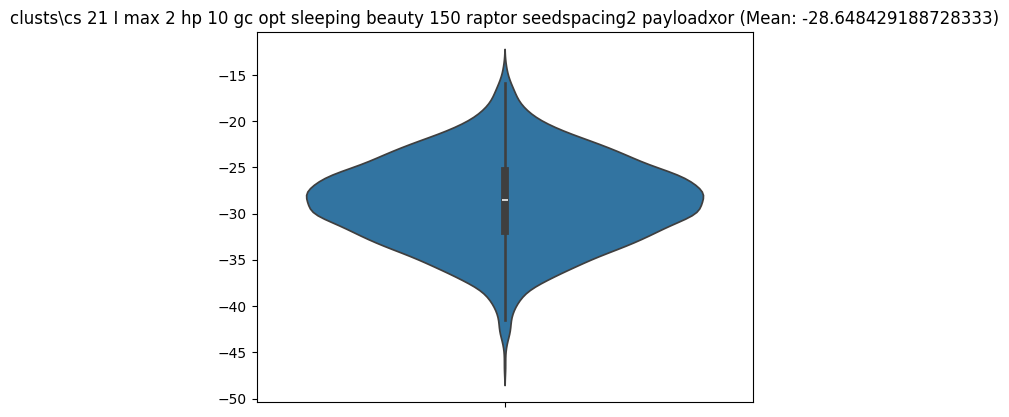

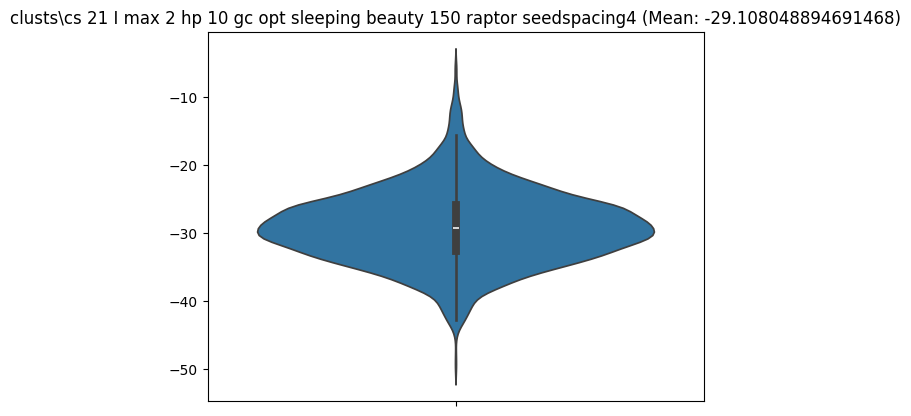

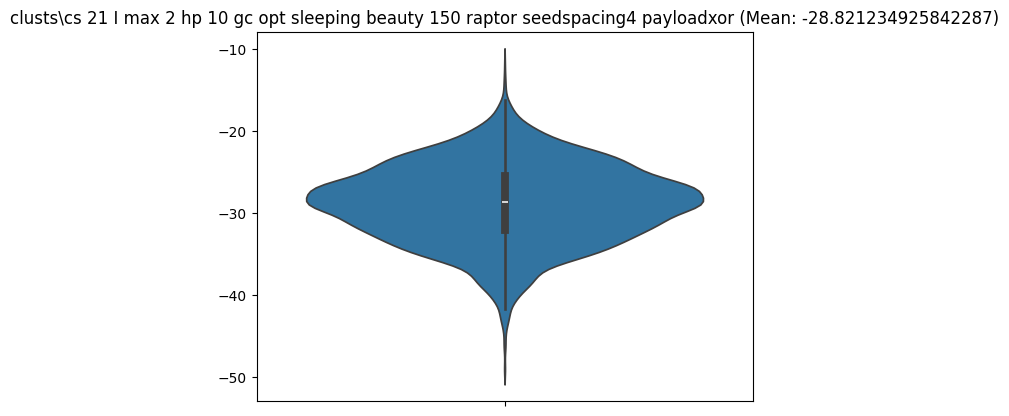

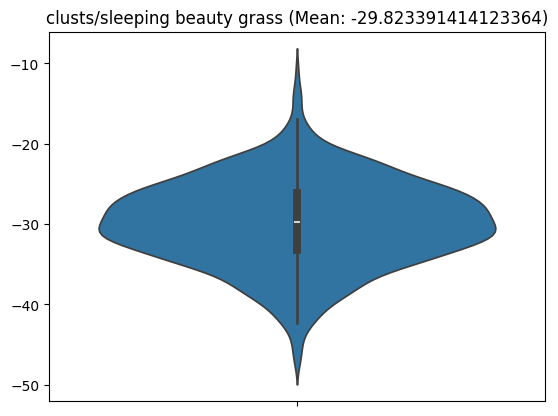

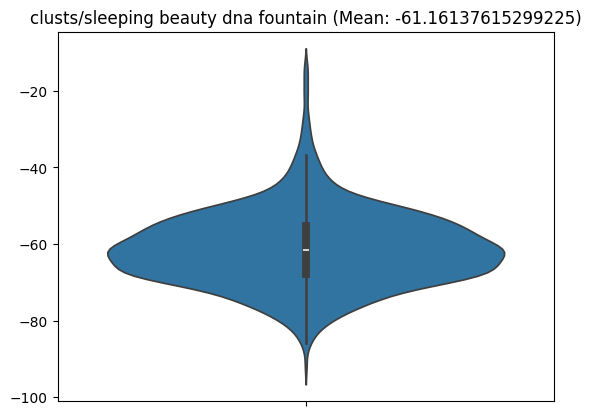

In [8]:
for key, value in df.items():
    # create a violin plot usin seaborn:
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.violinplot(data=df[key])
    key_title = key.replace('clusts\\cs_25_max_2_hp_10_gc_opt_sleeping_beauty_150_', '').replace('.fasta', '').replace('_', ' ')
    plt.title(f"{key_title} (Mean: {out[key]})")
    plt.show()
    

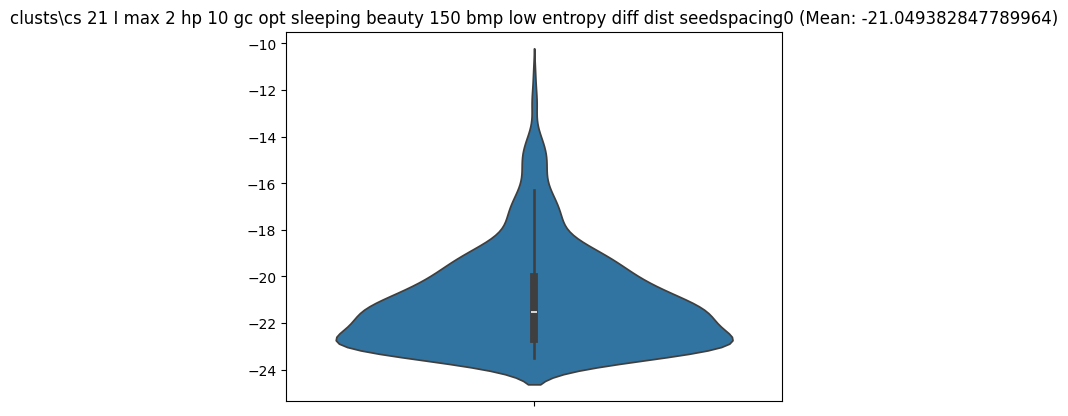

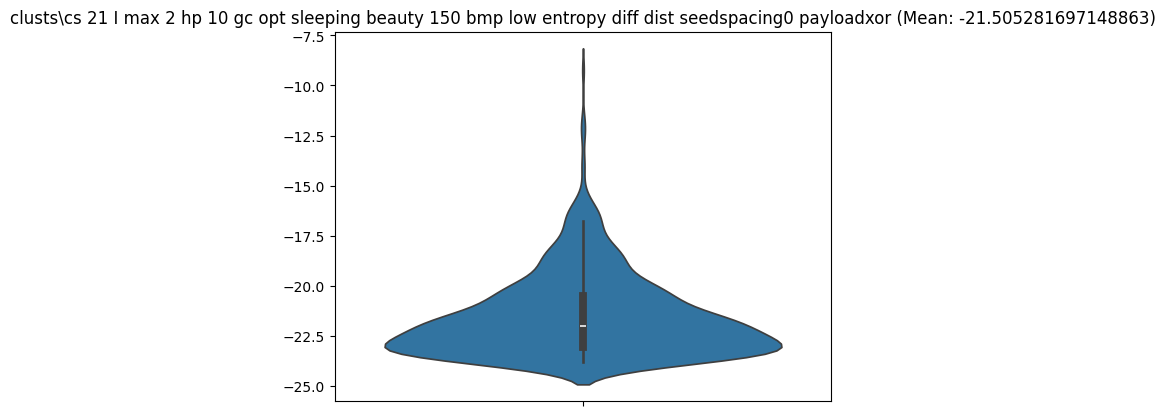

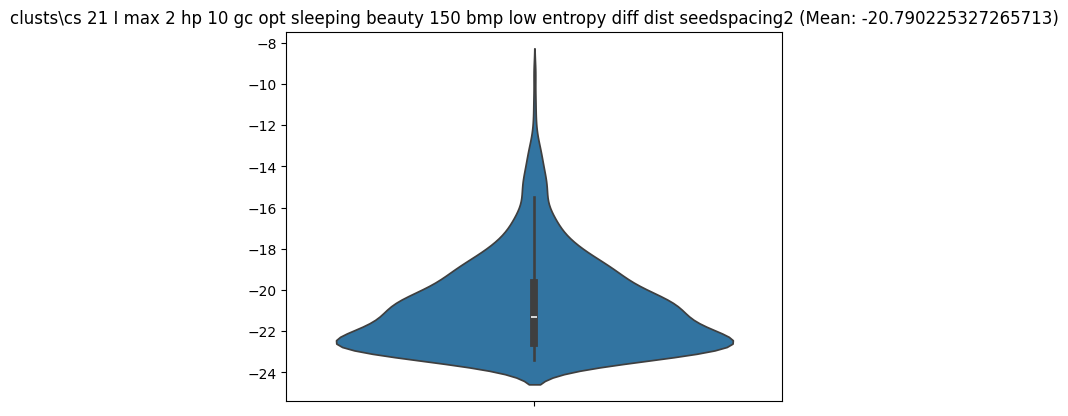

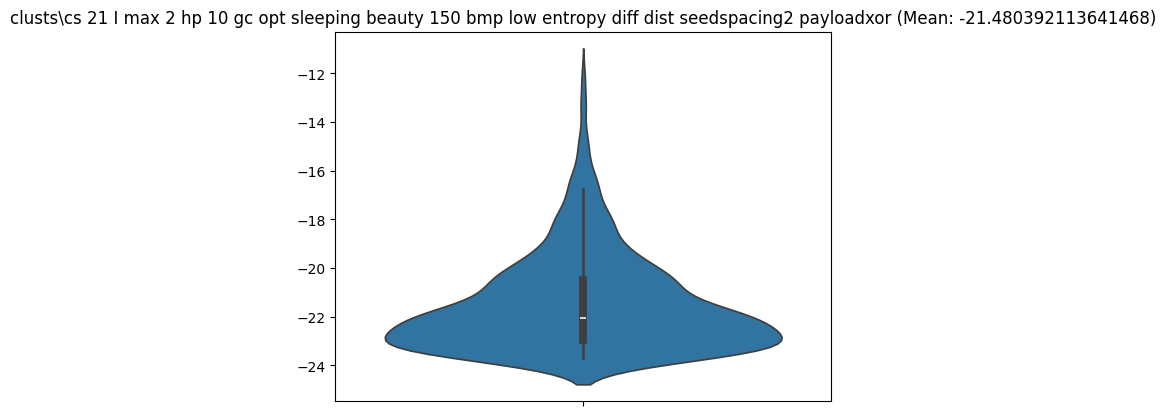

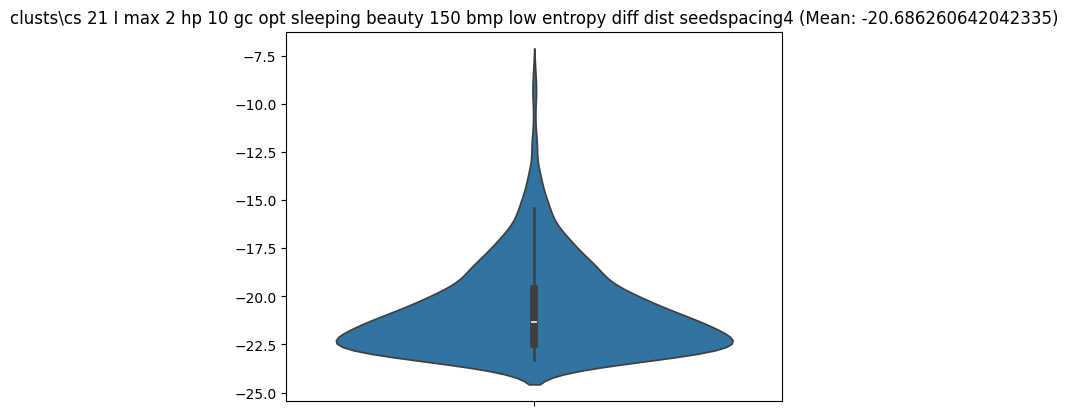

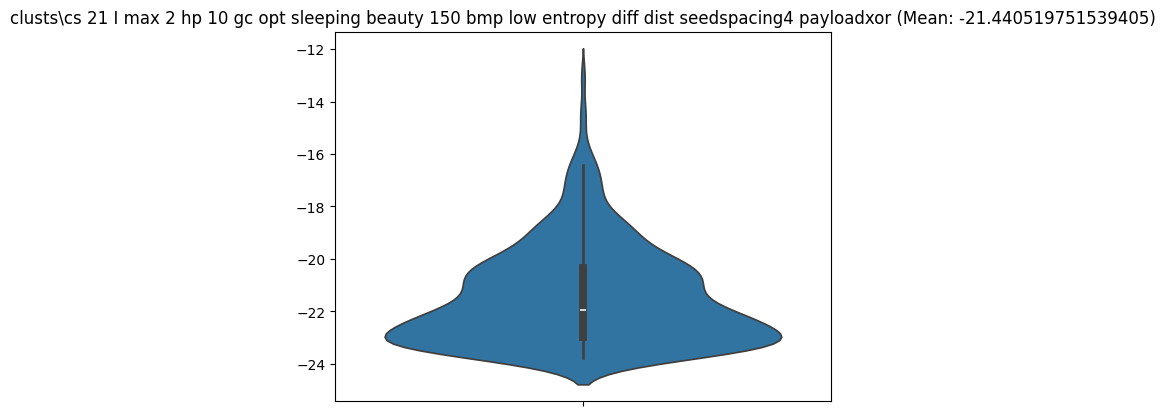

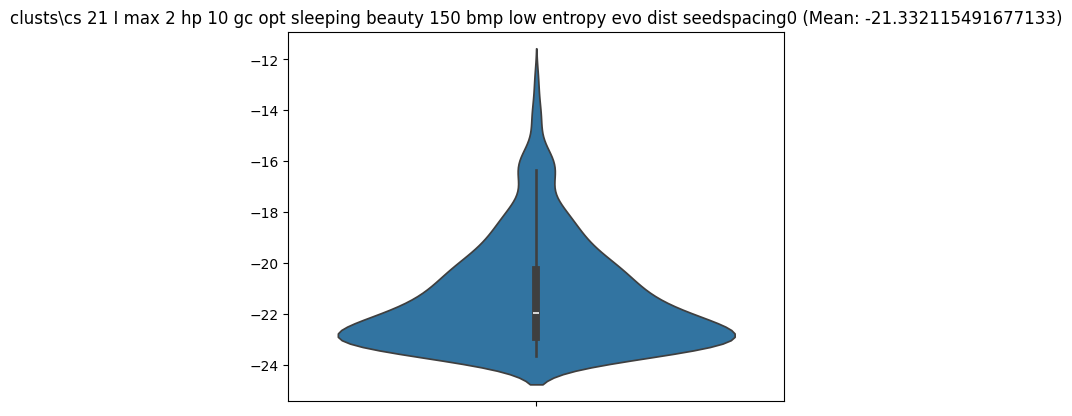

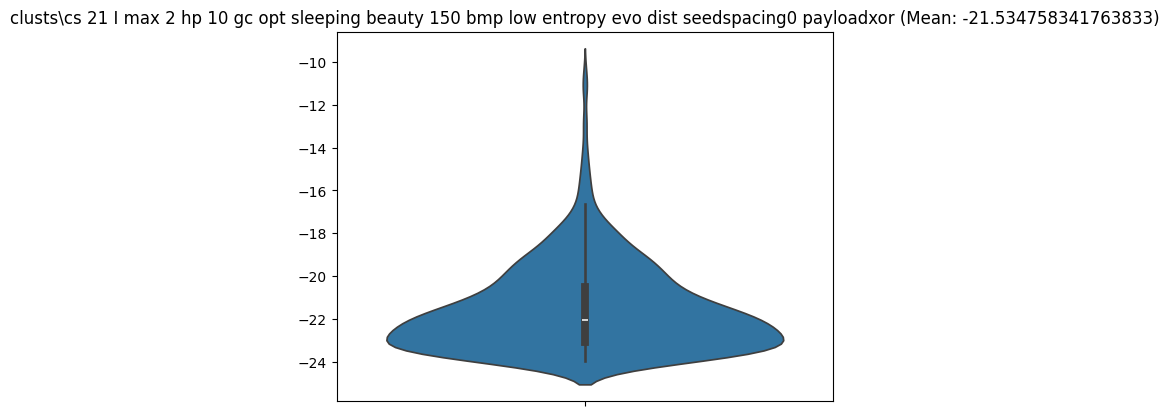

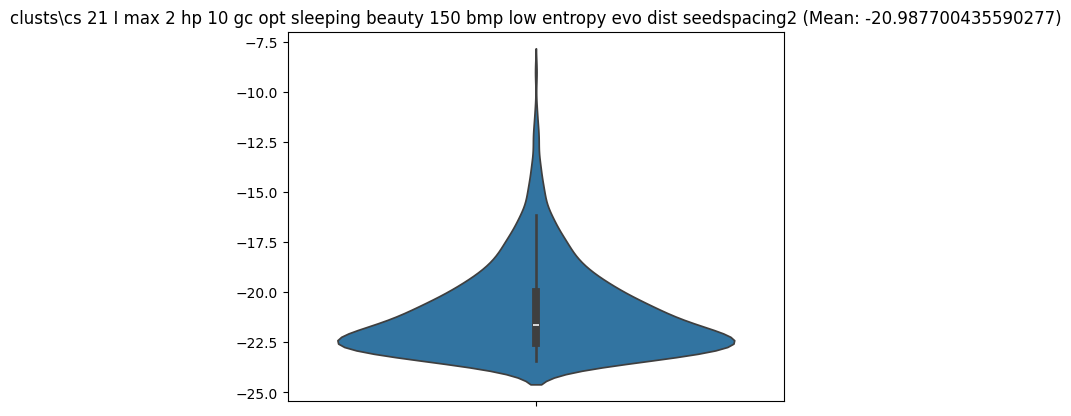

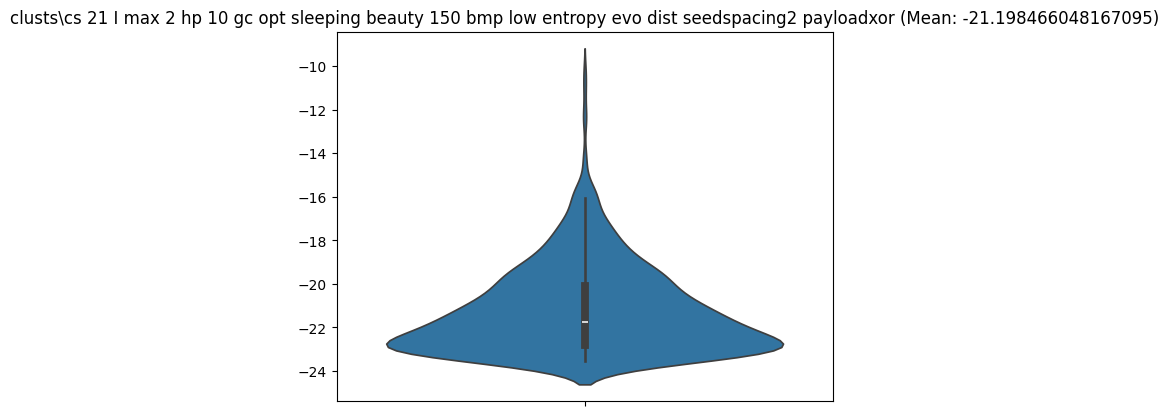

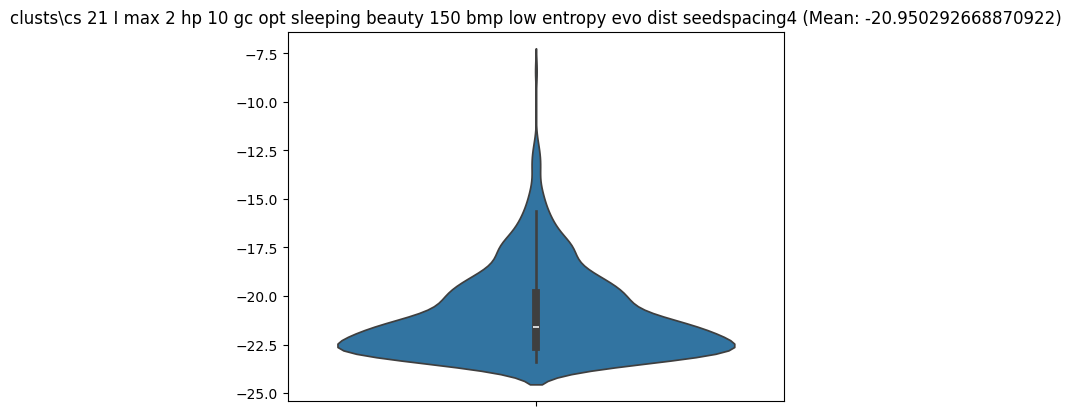

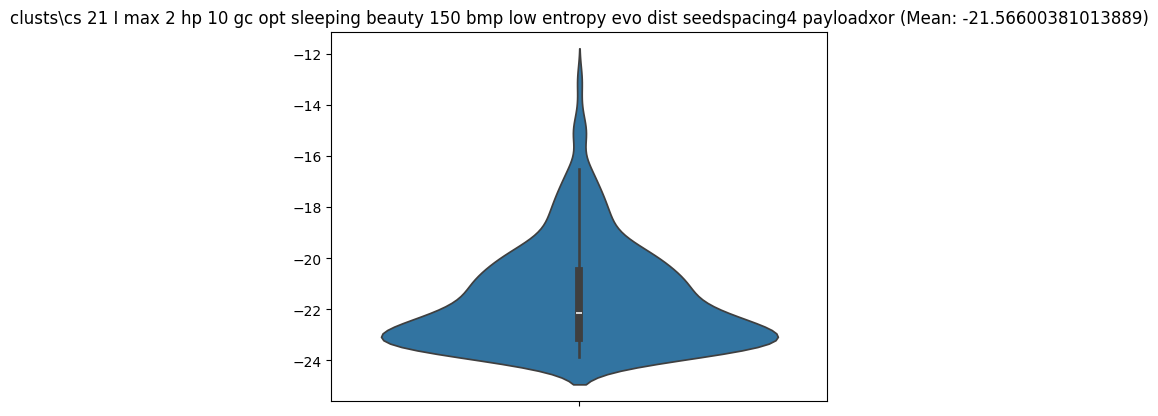

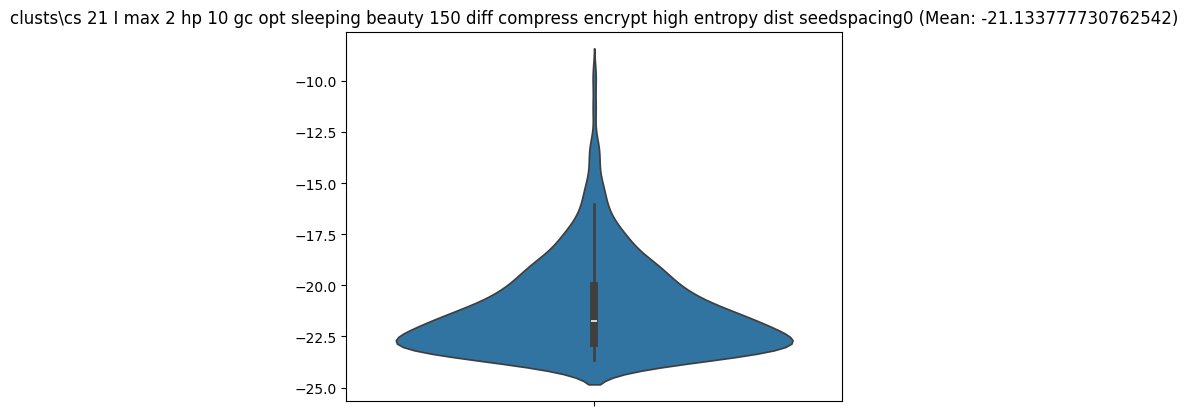

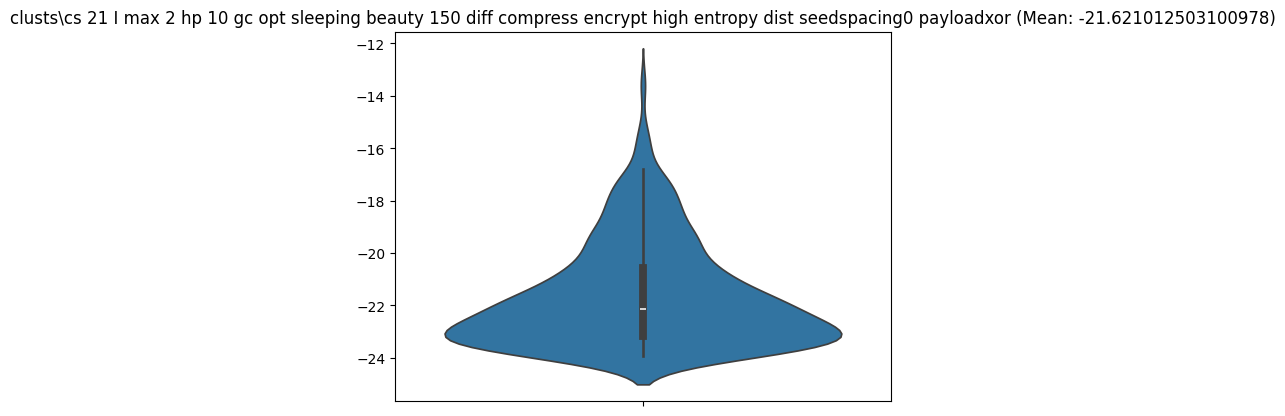

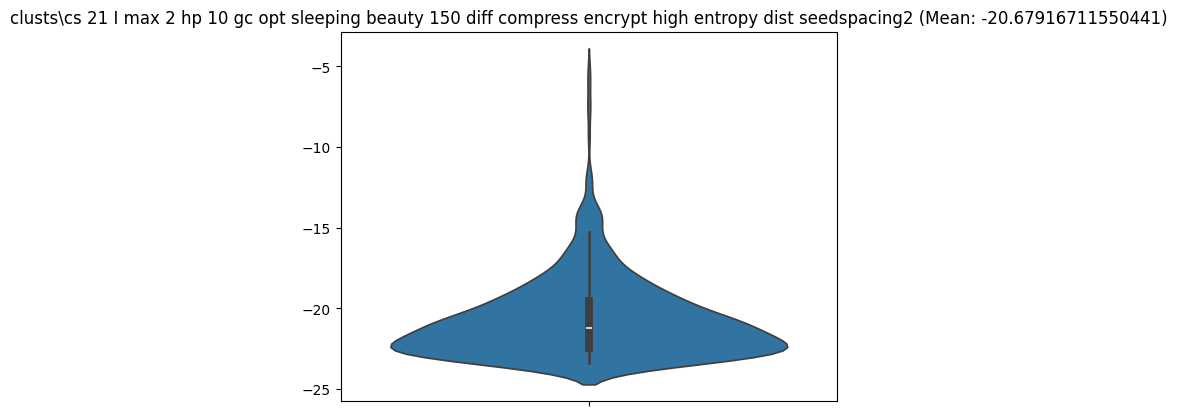

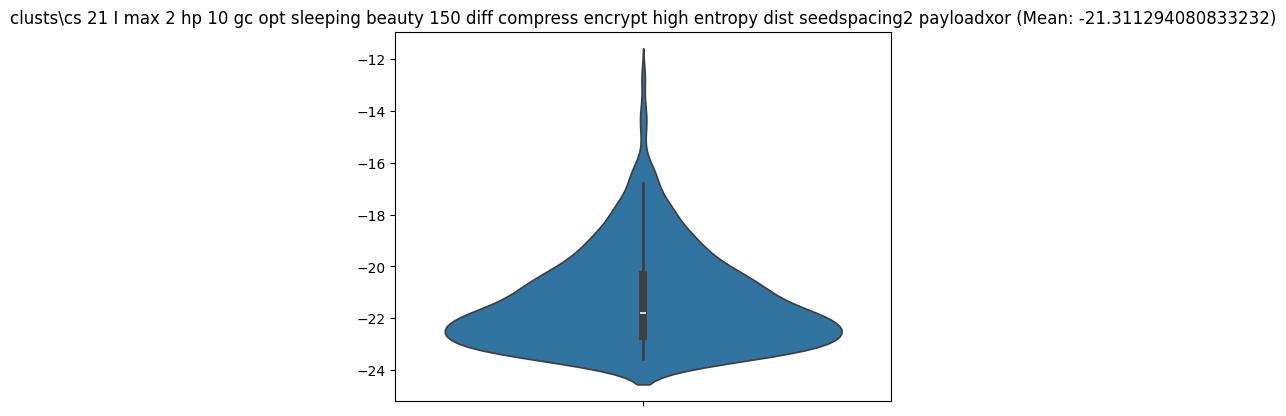

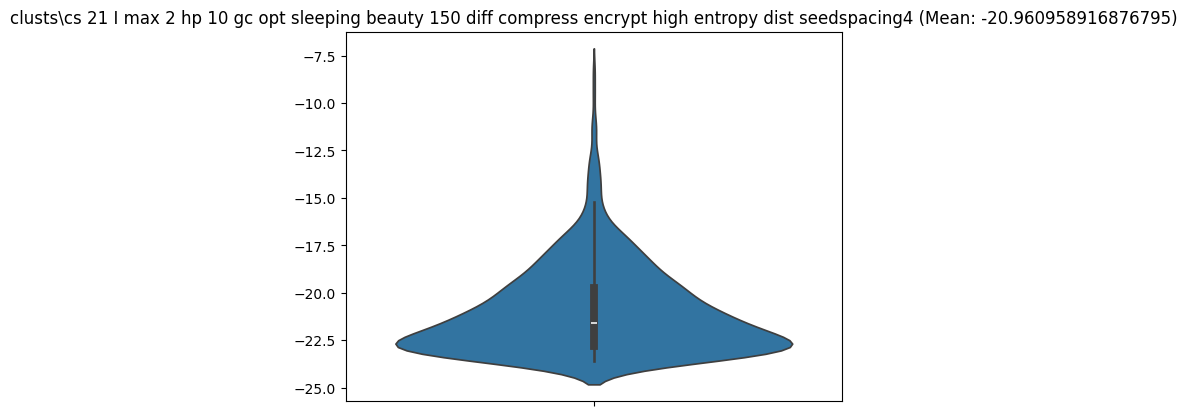

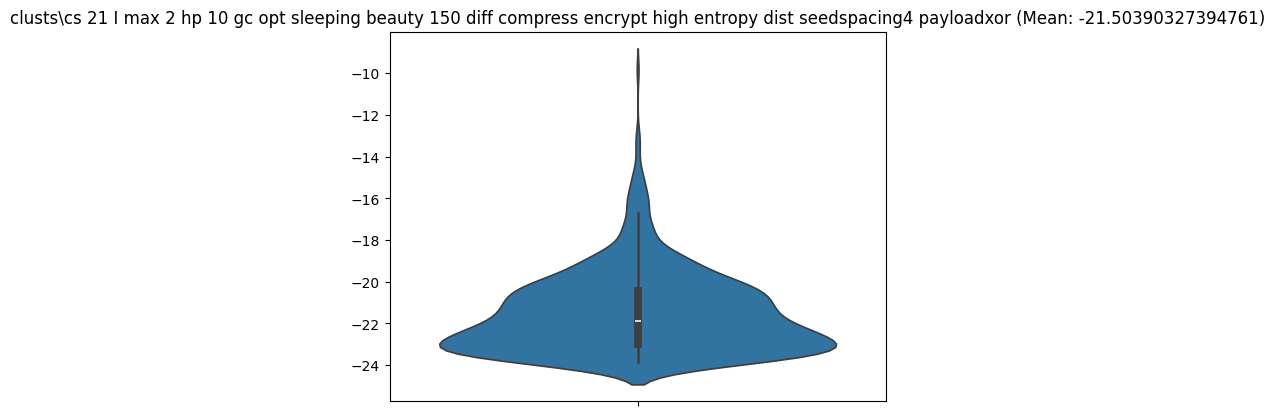

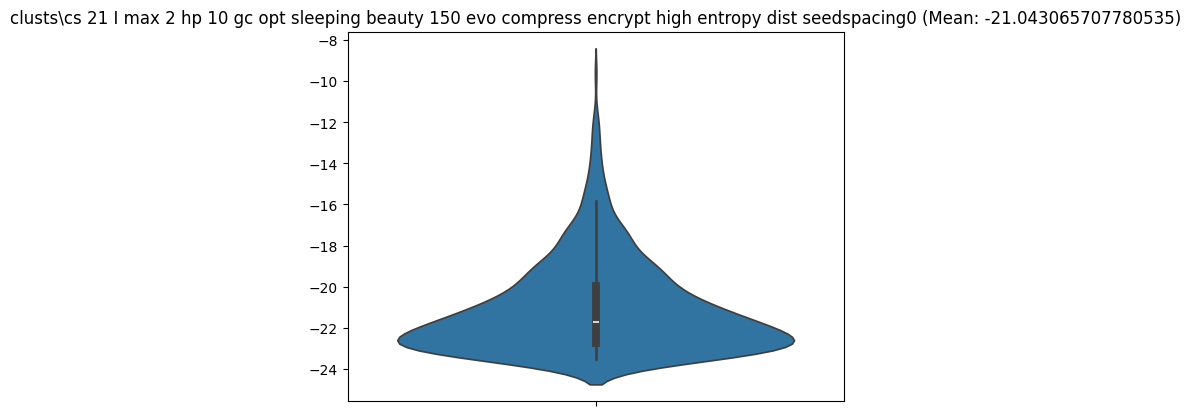

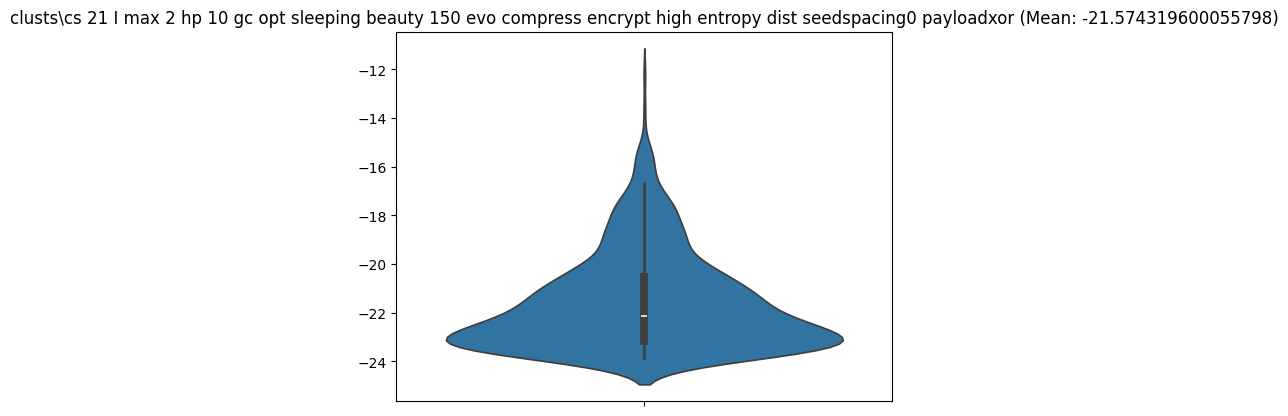

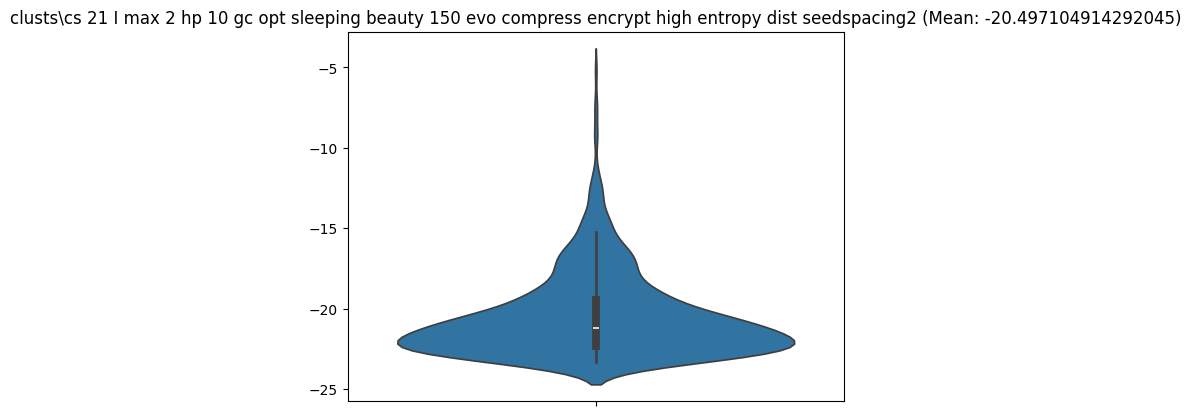

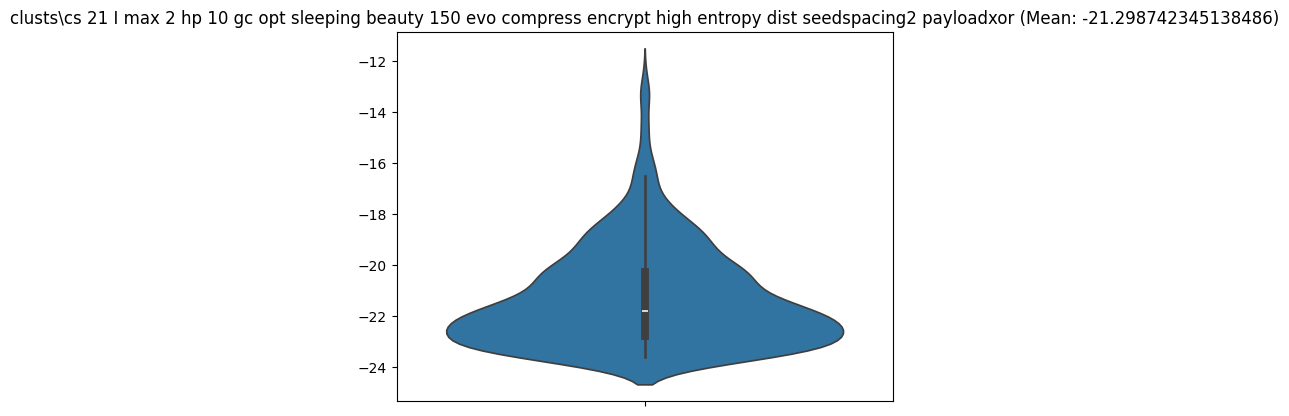

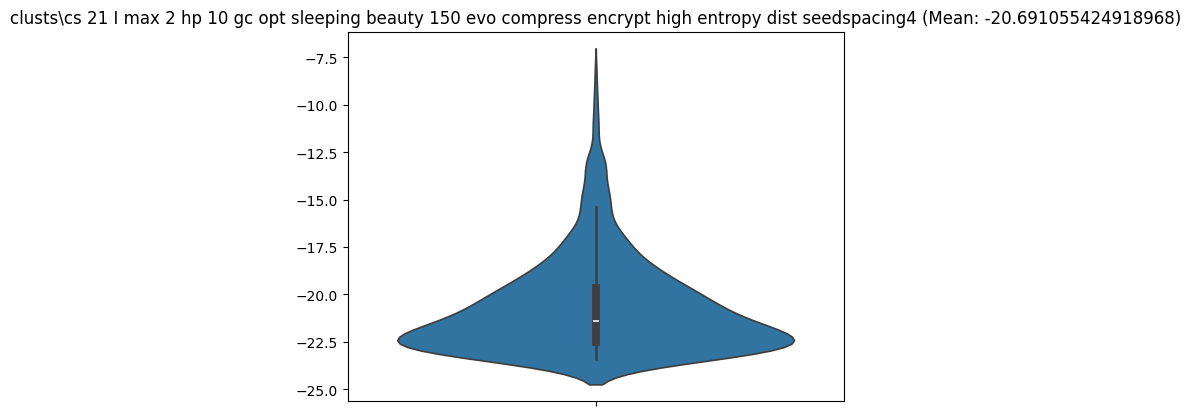

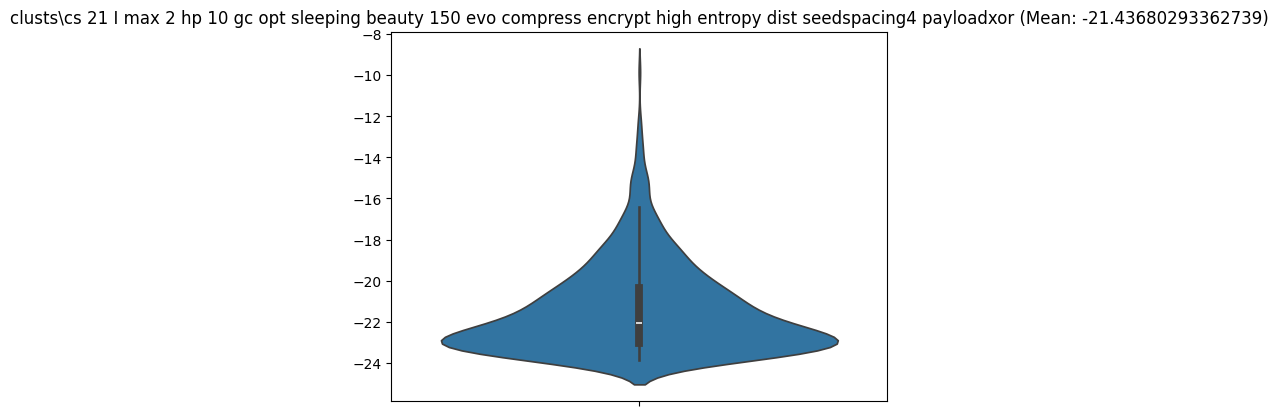

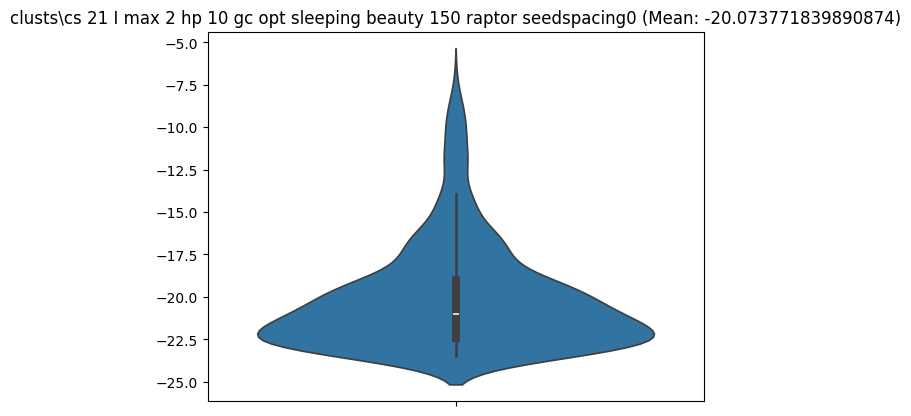

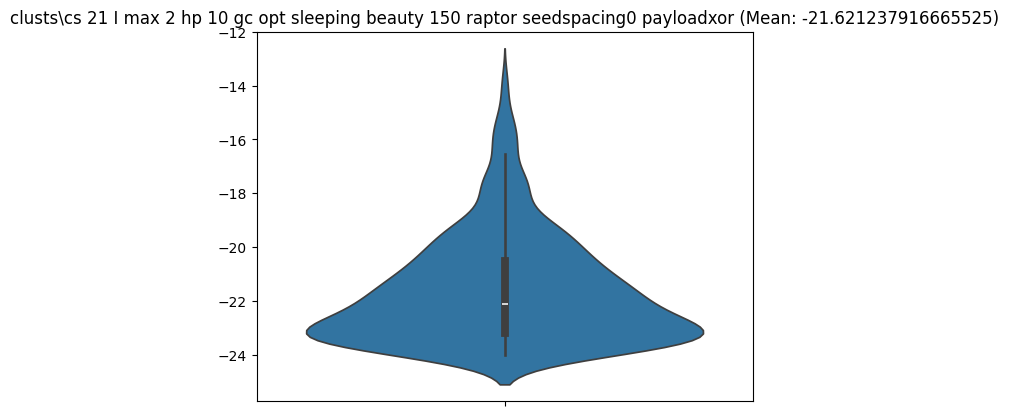

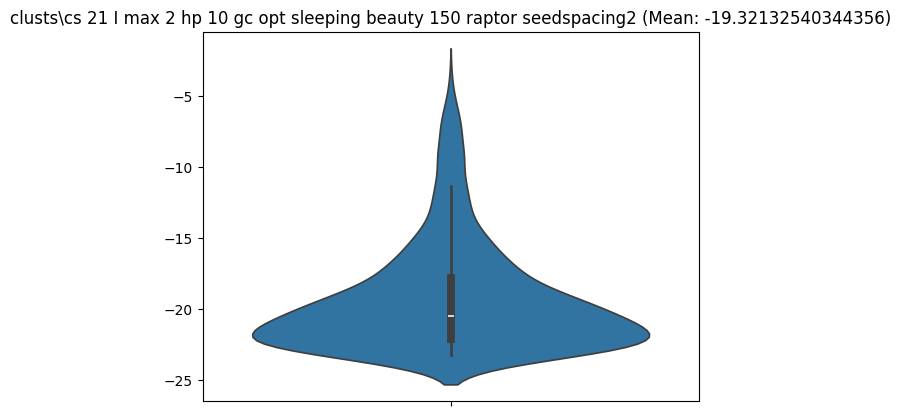

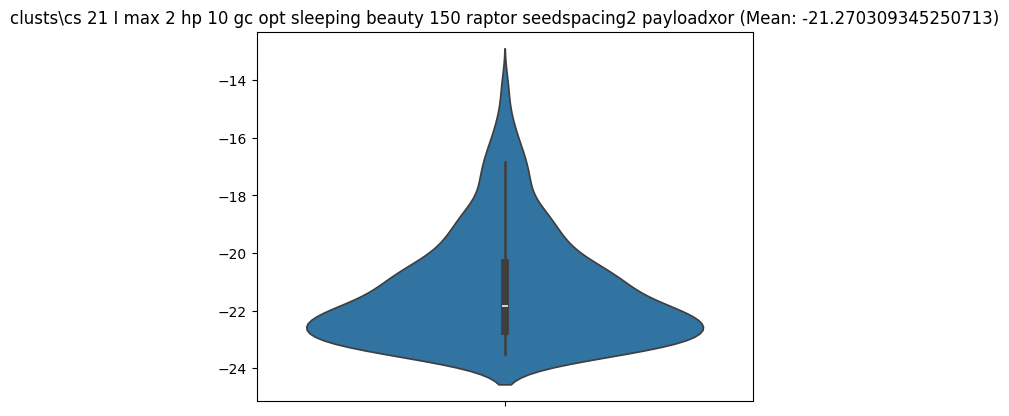

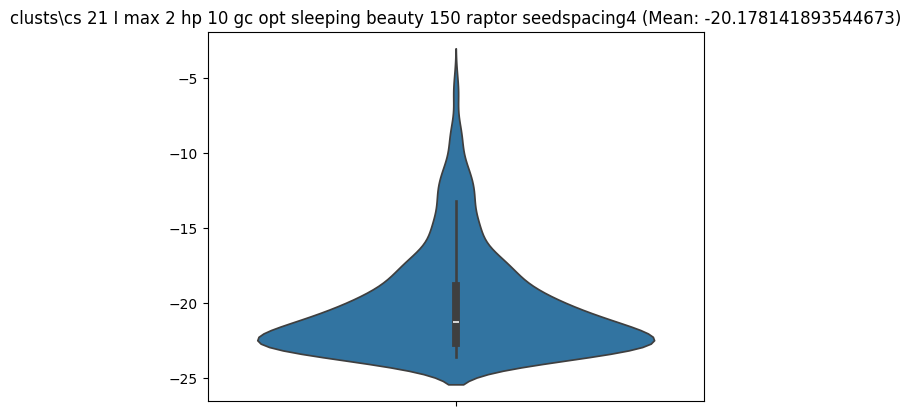

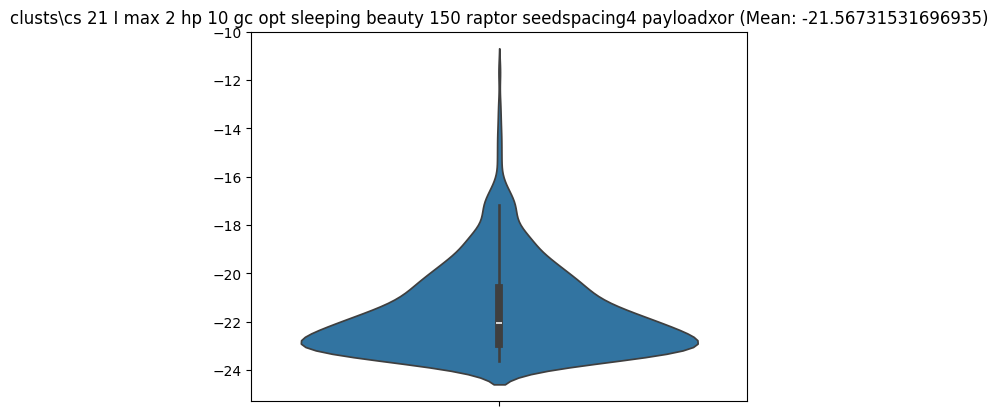

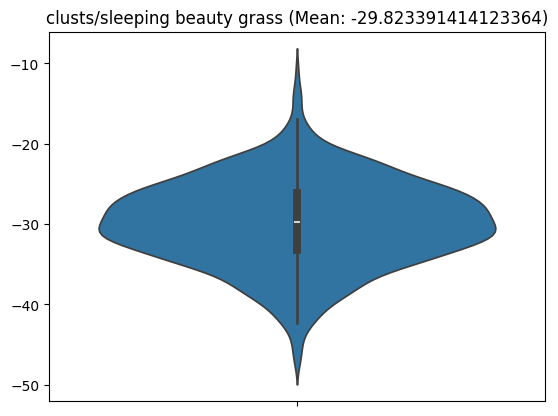

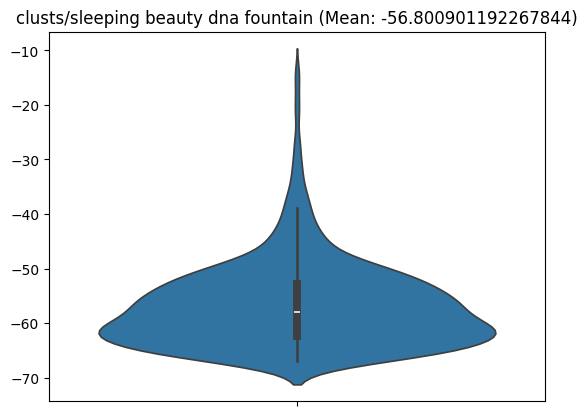

In [17]:
for key, value in df.items():
    value = sorted(value, reverse=True)[:713]
    # create a violin plot usin seaborn:
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.violinplot(data=value)
    key_title = key.replace('clusts\\cs_25_max_2_hp_10_gc_opt_sleeping_beauty_150_', '').replace('.fasta', '').replace('_', ' ')
    plt.title(f"{key_title} (Mean: {np.mean(value)})")
    plt.show()
    

In [94]:
a = "CCAGTTGCCTCCACGATTCCATTCTATTCATTCGAATAGGGTCAAACCCGTAATCACCGGAGACCCTGTCATGTTTCGTCTCCGTTGTAATCCAGGACAGCCCAAAGGTTCCCGTAGTGAAGCAAGCAAGGCCTCTTAAAGGCGTCCG"

In [95]:
len(a)

In [84]:
import RNA

In [96]:
rna = RNA.fold_compound(a)
pf = rna.pf()[1]

In [97]:
pf